# Transfer learning and fine-tuning

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# TensorFlow: Blas GEMM launch failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


## 1. Data preprocessing

### i. Data download

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


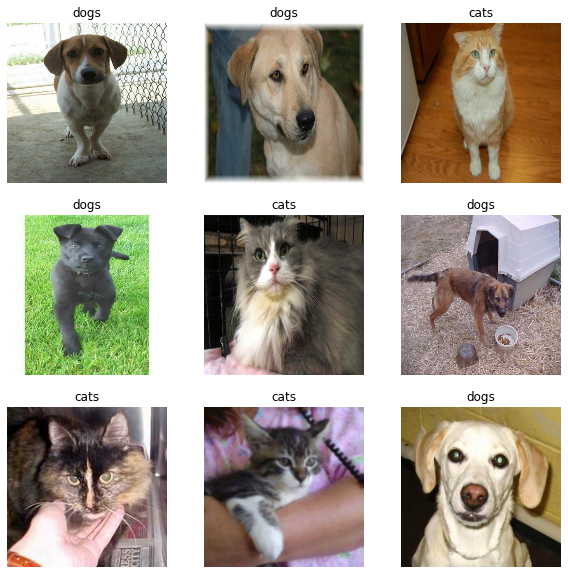

In [4]:
# Show the first nine images and labels from the training set:

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# As the original dataset doesn't contains a test set, you will create one. 
# To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, 
# then move 20% of them to a test set.

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### ii. Configure the dataset for performance

In [7]:
# Use buffered prefetching to load images from disk without having I/O become blocking. 
# To learn more about this method see the data performance guide.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### iii. Use data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

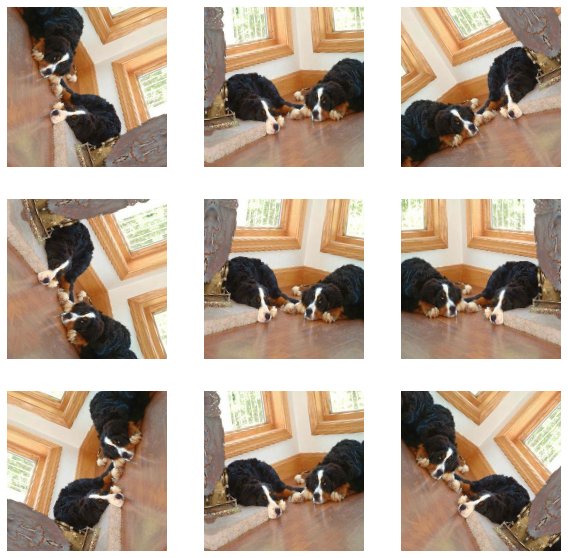

In [9]:
# Let's repeatedly apply these layers to the same image and see the result.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### iv. Rescale pixel values

In [10]:
# In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. 
# This model expects pixel values in [-1,1], but at this point, the pixel values in your images are in [0-255]. 
# To rescale them, use the preprocessing method included with the model.

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## 2. Create the base model from the pre-trained convnets

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.
# Let's see what it does to an example batch of images:

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 3. Feature extraction

### i. Freeze the convolutional base

In [14]:
base_model.trainable = False

### ii. Important note about BatchNormalization layers

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### iii. Add a classification head

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### iv. Compile the model

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [21]:
len(model.trainable_variables)

2

### v. Train the model

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 38ms/step - loss: 0.9044 - accuracy: 0.3816


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.92
initial accuracy: 0.39


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 7s 65ms/step - loss: 0.7931 - accuracy: 0.4980 - val_loss: 0.6219 - val_accuracy: 0.6176
Epoch 2/10
63/63 [==============================] - 3s 48ms/step - loss: 0.5852 - accuracy: 0.6400 - val_loss: 0.4434 - val_accuracy: 0.7649
Epoch 3/10
63/63 [==============================] - 3s 48ms/step - loss: 0.4567 - accuracy: 0.7505 - val_loss: 0.3370 - val_accuracy: 0.8601
Epoch 4/10
63/63 [==============================] - 3s 48ms/step - loss: 0.3979 - accuracy: 0.8090 - val_loss: 0.2712 - val_accuracy: 0.8985
Epoch 5/10
63/63 [==============================] - 3s 48ms/step - loss: 0.3329 - accuracy: 0.8385 - val_loss: 0.2277 - val_accuracy: 0.9121
Epoch 6/10
63/63 [==============================] - 3s 49ms/step - loss: 0.2995 - accuracy: 0.8750 - val_loss: 0.1955 - val_accuracy: 0.9344
Epoch 7/10
63/63 [==============================] - 3s 49ms/step - loss: 0.2643 - accuracy: 0.8860 - val_loss: 0.1731 - val_accuracy: 0.9455
Epoch 8/10
63

### vi. Learning curves

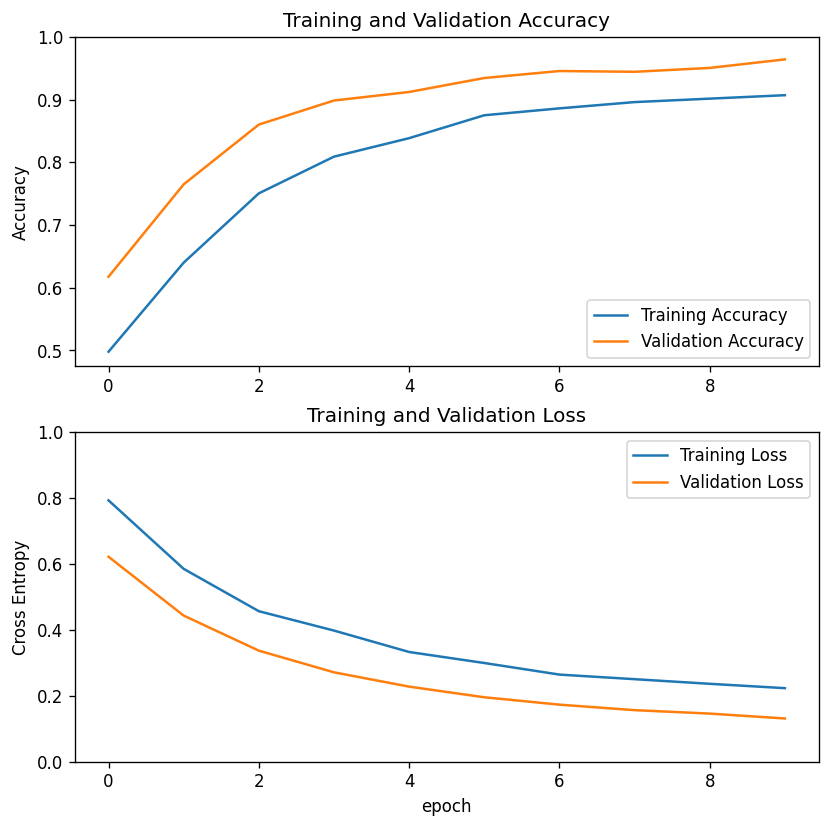

In [25]:
# Let's take a look at the learning curves of the training and validation accuracy/loss 
# when using the MobileNet V2 base model as a fixed feature extractor.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8), dpi=120)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 4. Fine tuning

### i. Un-freeze the top layers of the model

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### ii. Compile the model

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [30]:
len(model.trainable_variables)

56

### iii. Continue training the model

In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 9s 76ms/step - loss: 0.1885 - accuracy: 0.9181 - val_loss: 0.0602 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 4s 63ms/step - loss: 0.1399 - accuracy: 0.9420 - val_loss: 0.0523 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 4s 62ms/step - loss: 0.1082 - accuracy: 0.9565 - val_loss: 0.0471 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 4s 63ms/step - loss: 0.0853 - accuracy: 0.9696 - val_loss: 0.0389 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 4s 63ms/step - loss: 0.0870 - accuracy: 0.9683 - val_loss: 0.0506 - val_accuracy: 0.9765
Epoch 15/20
63/63 [==============================] - 4s 63ms/step - loss: 0.0867 - accuracy: 0.9642 - val_loss: 0.0494 - val_accuracy: 0.9765
Epoch 16/20
63/63 [==============================] - 4s 63ms/step - loss: 0.0912 - accuracy: 0.9675 - val_loss: 0.0497 - val_accuracy: 0.9777
Epoch 

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

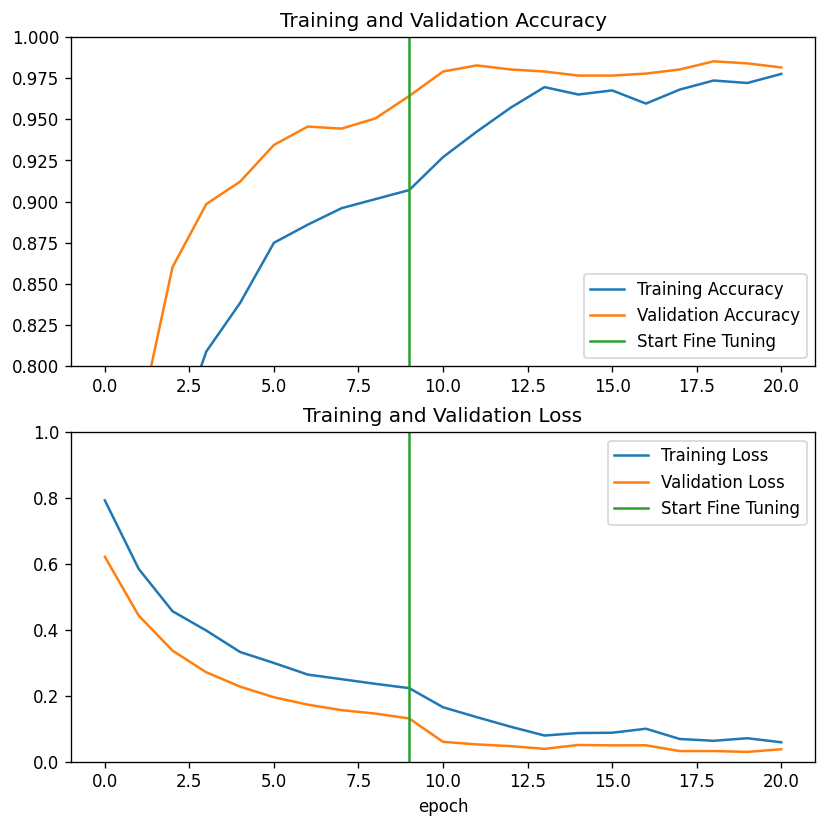

In [33]:
plt.figure(figsize=(8, 8), dpi=120)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### iv. Evaluation and prediction

In [34]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 33ms/step - loss: 0.0349 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


Predictions:
 [1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1]
Labels:
 [1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1]


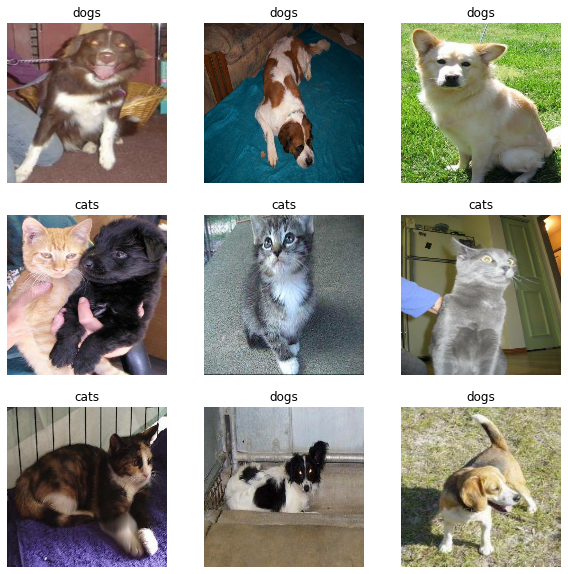

In [35]:
# And now you are all set to use this model to predict if your pet is a cat or dog.

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## 5. Summary

**Using a pre-trained model for feature extraction**: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

**Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

# reference

### https://tensorflow.google.cn/tutorials/images/transfer_learning#summary